<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-Fred-Sheppard/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [96]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [97]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [98]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=train_transform, train=True)
    test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=test_transform, train=False)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [99]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool  = nn.MaxPool2d(2,2)

        if useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [100]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [101]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [102]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.290135  [   64/60000]
loss: 0.609140  [ 6464/60000]
loss: 0.460987  [12864/60000]
loss: 0.423722  [19264/60000]
loss: 0.378305  [25664/60000]
loss: 0.225114  [32064/60000]
loss: 0.426869  [38464/60000]
loss: 0.172476  [44864/60000]
loss: 0.271275  [51264/60000]
loss: 0.386114  [57664/60000]


Epochs:  10%|█         | 1/10 [00:29<04:21, 29.01s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.284631 

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.310013 

Epoch 2:

loss: 0.352248  [   64/60000]
loss: 0.188348  [ 6464/60000]
loss: 0.174631  [12864/60000]
loss: 0.322171  [19264/60000]
loss: 0.291865  [25664/60000]
loss: 0.185547  [32064/60000]
loss: 0.146686  [38464/60000]
loss: 0.230982  [44864/60000]
loss: 0.298710  [51264/60000]
loss: 0.206092  [57664/60000]


Epochs:  20%|██        | 2/10 [00:57<03:48, 28.52s/it]

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.210016 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.252590 

Epoch 3:

loss: 0.145352  [   64/60000]
loss: 0.089966  [ 6464/60000]
loss: 0.144264  [12864/60000]
loss: 0.218939  [19264/60000]
loss: 0.313497  [25664/60000]
loss: 0.115830  [32064/60000]
loss: 0.155519  [38464/60000]
loss: 0.193463  [44864/60000]
loss: 0.300414  [51264/60000]
loss: 0.107344  [57664/60000]


Epochs:  30%|███       | 3/10 [01:27<03:23, 29.13s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.161057 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.224378 

Epoch 4:

loss: 0.273312  [   64/60000]
loss: 0.209827  [ 6464/60000]
loss: 0.155485  [12864/60000]
loss: 0.092871  [19264/60000]
loss: 0.147032  [25664/60000]
loss: 0.213792  [32064/60000]
loss: 0.223332  [38464/60000]
loss: 0.120077  [44864/60000]
loss: 0.162297  [51264/60000]
loss: 0.181786  [57664/60000]


Epochs:  40%|████      | 4/10 [01:56<02:54, 29.08s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.150617 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.234741 

Epoch 5:

loss: 0.156517  [   64/60000]
loss: 0.084242  [ 6464/60000]
loss: 0.058375  [12864/60000]
loss: 0.071130  [19264/60000]
loss: 0.077590  [25664/60000]
loss: 0.179280  [32064/60000]
loss: 0.106325  [38464/60000]
loss: 0.071465  [44864/60000]
loss: 0.196345  [51264/60000]
loss: 0.182061  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:25<02:25, 29.15s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.122501 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.229305 

Epoch 6:

loss: 0.099698  [   64/60000]
loss: 0.027472  [ 6464/60000]
loss: 0.068994  [12864/60000]
loss: 0.199720  [19264/60000]
loss: 0.149129  [25664/60000]
loss: 0.044349  [32064/60000]
loss: 0.237002  [38464/60000]
loss: 0.136214  [44864/60000]
loss: 0.141161  [51264/60000]
loss: 0.064584  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:55<01:57, 29.33s/it]

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.105496 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.250835 

Epoch 7:

loss: 0.068888  [   64/60000]
loss: 0.063076  [ 6464/60000]
loss: 0.049421  [12864/60000]
loss: 0.209433  [19264/60000]
loss: 0.079073  [25664/60000]
loss: 0.110964  [32064/60000]
loss: 0.151674  [38464/60000]
loss: 0.091045  [44864/60000]
loss: 0.094285  [51264/60000]
loss: 0.091483  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:23<01:27, 29.15s/it]

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.071316 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.244960 

Epoch 8:

loss: 0.019481  [   64/60000]
loss: 0.146491  [ 6464/60000]
loss: 0.031066  [12864/60000]
loss: 0.171859  [19264/60000]
loss: 0.170259  [25664/60000]
loss: 0.028453  [32064/60000]
loss: 0.195200  [38464/60000]
loss: 0.053867  [44864/60000]
loss: 0.037876  [51264/60000]
loss: 0.096688  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:52<00:58, 29.09s/it]

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.068051 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.302385 

Epoch 9:

loss: 0.120847  [   64/60000]
loss: 0.030276  [ 6464/60000]
loss: 0.097505  [12864/60000]
loss: 0.049930  [19264/60000]
loss: 0.017405  [25664/60000]
loss: 0.087367  [32064/60000]
loss: 0.020420  [38464/60000]
loss: 0.091699  [44864/60000]
loss: 0.106443  [51264/60000]
loss: 0.129081  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:21<00:28, 28.98s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.045155 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.284166 

Epoch 10:

loss: 0.068493  [   64/60000]
loss: 0.025170  [ 6464/60000]
loss: 0.069169  [12864/60000]
loss: 0.057806  [19264/60000]
loss: 0.075943  [25664/60000]
loss: 0.074992  [32064/60000]
loss: 0.059906  [38464/60000]
loss: 0.021458  [44864/60000]
loss: 0.057396  [51264/60000]
loss: 0.040812  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:50<00:00, 29.03s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.038852 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.343377 

Done training!


Plotting metrics

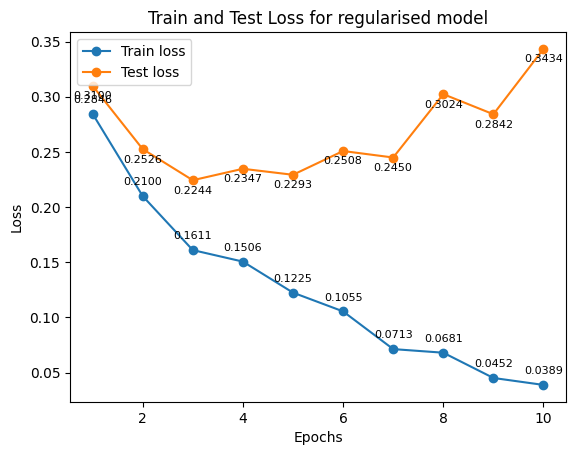

In [103]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

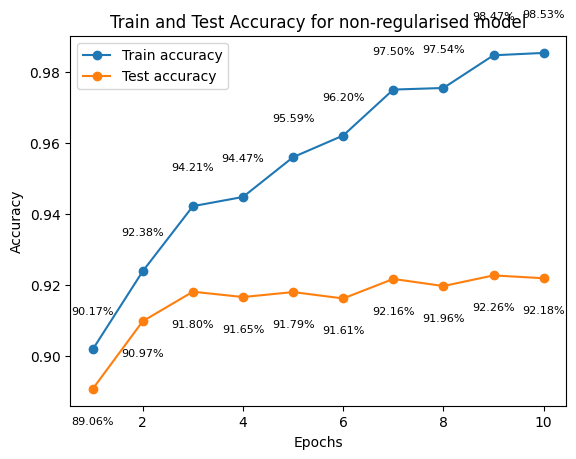

In [104]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [105]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion().to(device) # Getting the Fashion MNIST model

epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.283993  [   64/60000]
loss: 0.537518  [ 6464/60000]
loss: 0.459794  [12864/60000]
loss: 0.578928  [19264/60000]
loss: 0.494164  [25664/60000]
loss: 0.198344  [32064/60000]
loss: 0.204025  [38464/60000]
loss: 0.328467  [44864/60000]
loss: 0.330551  [51264/60000]
loss: 0.328826  [57664/60000]


Epochs:  10%|█         | 1/10 [00:28<04:19, 28.82s/it]

Train Error: 
 Accuracy: 89.8%, Avg loss: 0.279820 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.309636 

Epoch 2:

loss: 0.194840  [   64/60000]
loss: 0.249076  [ 6464/60000]
loss: 0.526589  [12864/60000]
loss: 0.231575  [19264/60000]
loss: 0.195797  [25664/60000]
loss: 0.316898  [32064/60000]
loss: 0.267309  [38464/60000]
loss: 0.218315  [44864/60000]
loss: 0.232215  [51264/60000]
loss: 0.177931  [57664/60000]


Epochs:  20%|██        | 2/10 [00:57<03:48, 28.56s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.219935 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.262488 

Epoch 3:

loss: 0.289502  [   64/60000]
loss: 0.232242  [ 6464/60000]
loss: 0.180210  [12864/60000]
loss: 0.299177  [19264/60000]
loss: 0.200547  [25664/60000]
loss: 0.172781  [32064/60000]
loss: 0.093355  [38464/60000]
loss: 0.173603  [44864/60000]
loss: 0.123375  [51264/60000]
loss: 0.194867  [57664/60000]


Epochs:  30%|███       | 3/10 [01:26<03:22, 28.89s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.184725 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.242723 

Epoch 4:

loss: 0.261186  [   64/60000]
loss: 0.134078  [ 6464/60000]
loss: 0.250344  [12864/60000]
loss: 0.212676  [19264/60000]
loss: 0.170607  [25664/60000]
loss: 0.196052  [32064/60000]
loss: 0.290732  [38464/60000]
loss: 0.159792  [44864/60000]
loss: 0.124612  [51264/60000]
loss: 0.100331  [57664/60000]


Epochs:  40%|████      | 4/10 [01:54<02:52, 28.71s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.139246 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.222826 

Epoch 5:

loss: 0.139922  [   64/60000]
loss: 0.065552  [ 6464/60000]
loss: 0.128712  [12864/60000]
loss: 0.158459  [19264/60000]
loss: 0.080974  [25664/60000]
loss: 0.076086  [32064/60000]
loss: 0.186973  [38464/60000]
loss: 0.255872  [44864/60000]
loss: 0.092277  [51264/60000]
loss: 0.158118  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:23<02:23, 28.67s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.116295 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.220225 

Epoch 6:

loss: 0.141208  [   64/60000]
loss: 0.204127  [ 6464/60000]
loss: 0.146597  [12864/60000]
loss: 0.159520  [19264/60000]
loss: 0.072729  [25664/60000]
loss: 0.107769  [32064/60000]
loss: 0.194395  [38464/60000]
loss: 0.141391  [44864/60000]
loss: 0.111723  [51264/60000]
loss: 0.168588  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:52<01:55, 28.78s/it]

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.093507 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.254722 

Epoch 7:

loss: 0.174360  [   64/60000]
loss: 0.179941  [ 6464/60000]
loss: 0.076791  [12864/60000]
loss: 0.082429  [19264/60000]
loss: 0.138441  [25664/60000]
loss: 0.090661  [32064/60000]
loss: 0.292416  [38464/60000]
loss: 0.056288  [44864/60000]
loss: 0.222812  [51264/60000]
loss: 0.175211  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:20<01:25, 28.64s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.078917 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.252067 

Epoch 8:

loss: 0.050962  [   64/60000]
loss: 0.039886  [ 6464/60000]
loss: 0.018323  [12864/60000]
loss: 0.121191  [19264/60000]
loss: 0.107888  [25664/60000]
loss: 0.167289  [32064/60000]
loss: 0.087791  [38464/60000]
loss: 0.066758  [44864/60000]
loss: 0.085873  [51264/60000]
loss: 0.090007  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:49<00:57, 28.65s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.053710 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.241662 

Epoch 9:

loss: 0.065329  [   64/60000]
loss: 0.011404  [ 6464/60000]
loss: 0.042797  [12864/60000]
loss: 0.114152  [19264/60000]
loss: 0.073183  [25664/60000]
loss: 0.049393  [32064/60000]
loss: 0.163184  [38464/60000]
loss: 0.035390  [44864/60000]
loss: 0.028248  [51264/60000]
loss: 0.079664  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:17<00:28, 28.41s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.055833 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.296613 

Epoch 10:

loss: 0.027258  [   64/60000]
loss: 0.032570  [ 6464/60000]
loss: 0.042527  [12864/60000]
loss: 0.014030  [19264/60000]
loss: 0.063386  [25664/60000]
loss: 0.047738  [32064/60000]
loss: 0.086538  [38464/60000]
loss: 0.183389  [44864/60000]
loss: 0.128847  [51264/60000]
loss: 0.112161  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:45<00:00, 28.59s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.041770 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.309806 

Done training!


Plotting metrics

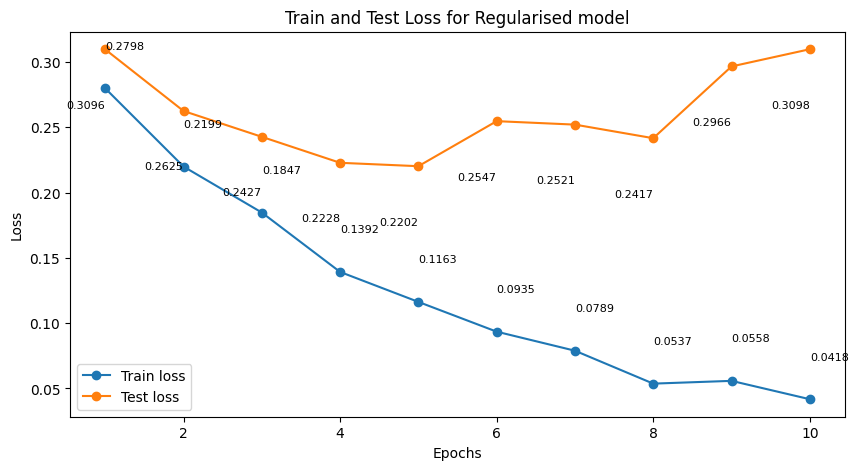

In [106]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

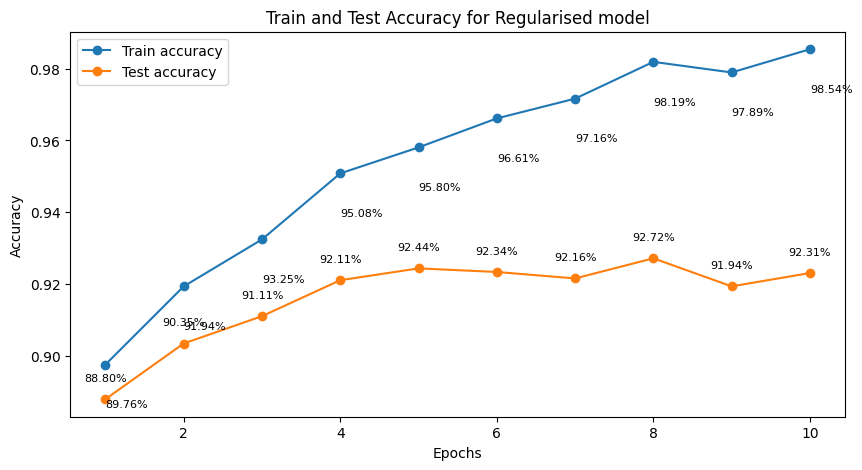

In [107]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [108]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64)

model = NetFashion(useRegularization=True).to(device) # Getting the Fashion MNIST model
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.304484  [   64/60000]
loss: 0.616749  [ 6464/60000]
loss: 0.443109  [12864/60000]
loss: 0.389178  [19264/60000]
loss: 0.434708  [25664/60000]
loss: 0.309863  [32064/60000]
loss: 0.291573  [38464/60000]
loss: 0.245498  [44864/60000]
loss: 0.439969  [51264/60000]
loss: 0.190886  [57664/60000]


Epochs:  10%|█         | 1/10 [00:28<04:20, 28.99s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.291289 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.317188 

Epoch 2:

loss: 0.186742  [   64/60000]
loss: 0.179803  [ 6464/60000]
loss: 0.287044  [12864/60000]
loss: 0.248417  [19264/60000]
loss: 0.170507  [25664/60000]
loss: 0.175377  [32064/60000]
loss: 0.176382  [38464/60000]
loss: 0.183351  [44864/60000]
loss: 0.137631  [51264/60000]
loss: 0.267227  [57664/60000]


Epochs:  20%|██        | 2/10 [00:57<03:47, 28.47s/it]

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.254040 

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.297293 

Epoch 3:

loss: 0.334936  [   64/60000]
loss: 0.255094  [ 6464/60000]
loss: 0.352726  [12864/60000]
loss: 0.348779  [19264/60000]
loss: 0.259742  [25664/60000]
loss: 0.270747  [32064/60000]
loss: 0.181285  [38464/60000]
loss: 0.273324  [44864/60000]
loss: 0.266397  [51264/60000]
loss: 0.138360  [57664/60000]


Epochs:  30%|███       | 3/10 [01:25<03:19, 28.53s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.174639 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.236614 

Epoch 4:

loss: 0.261771  [   64/60000]
loss: 0.172656  [ 6464/60000]
loss: 0.185752  [12864/60000]
loss: 0.141655  [19264/60000]
loss: 0.262894  [25664/60000]
loss: 0.187167  [32064/60000]
loss: 0.078653  [38464/60000]
loss: 0.212483  [44864/60000]
loss: 0.188800  [51264/60000]
loss: 0.155174  [57664/60000]


Epochs:  40%|████      | 4/10 [01:53<02:49, 28.32s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.152094 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.227078 

Epoch 5:

loss: 0.071280  [   64/60000]
loss: 0.133678  [ 6464/60000]
loss: 0.074794  [12864/60000]
loss: 0.128642  [19264/60000]
loss: 0.047325  [25664/60000]
loss: 0.177692  [32064/60000]
loss: 0.131697  [38464/60000]
loss: 0.187700  [44864/60000]
loss: 0.100894  [51264/60000]
loss: 0.203554  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:21<02:21, 28.26s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.126946 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.231862 

Epoch 6:

loss: 0.139961  [   64/60000]
loss: 0.113603  [ 6464/60000]
loss: 0.114094  [12864/60000]
loss: 0.137728  [19264/60000]
loss: 0.177891  [25664/60000]
loss: 0.127562  [32064/60000]
loss: 0.113591  [38464/60000]
loss: 0.248784  [44864/60000]
loss: 0.095109  [51264/60000]
loss: 0.132772  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:50<01:53, 28.27s/it]

Train Error: 
 Accuracy: 96.7%, Avg loss: 0.093988 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.223690 

Epoch 7:

loss: 0.176507  [   64/60000]
loss: 0.033999  [ 6464/60000]
loss: 0.034042  [12864/60000]
loss: 0.099435  [19264/60000]
loss: 0.113456  [25664/60000]
loss: 0.052358  [32064/60000]
loss: 0.056735  [38464/60000]
loss: 0.067063  [44864/60000]
loss: 0.127670  [51264/60000]
loss: 0.099831  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:18<01:24, 28.21s/it]

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.085300 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.277980 

Epoch 8:

loss: 0.093582  [   64/60000]
loss: 0.142865  [ 6464/60000]
loss: 0.061062  [12864/60000]
loss: 0.098866  [19264/60000]
loss: 0.110420  [25664/60000]
loss: 0.066464  [32064/60000]
loss: 0.126436  [38464/60000]
loss: 0.106575  [44864/60000]
loss: 0.043231  [51264/60000]
loss: 0.097962  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:46<00:56, 28.35s/it]

Train Error: 
 Accuracy: 96.9%, Avg loss: 0.082671 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.273398 

Epoch 9:

loss: 0.216788  [   64/60000]
loss: 0.009340  [ 6464/60000]
loss: 0.046953  [12864/60000]
loss: 0.045862  [19264/60000]
loss: 0.056142  [25664/60000]
loss: 0.050565  [32064/60000]
loss: 0.098564  [38464/60000]
loss: 0.094810  [44864/60000]
loss: 0.012026  [51264/60000]
loss: 0.035206  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:15<00:28, 28.42s/it]

Train Error: 
 Accuracy: 98.1%, Avg loss: 0.051694 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.299448 

Epoch 10:

loss: 0.061075  [   64/60000]
loss: 0.011433  [ 6464/60000]
loss: 0.098546  [12864/60000]
loss: 0.036516  [19264/60000]
loss: 0.112612  [25664/60000]
loss: 0.075341  [32064/60000]
loss: 0.073138  [38464/60000]
loss: 0.037135  [44864/60000]
loss: 0.025200  [51264/60000]
loss: 0.150465  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:44<00:00, 28.41s/it]

Train Error: 
 Accuracy: 98.3%, Avg loss: 0.047347 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.327312 

Done training!


Plotting metrics

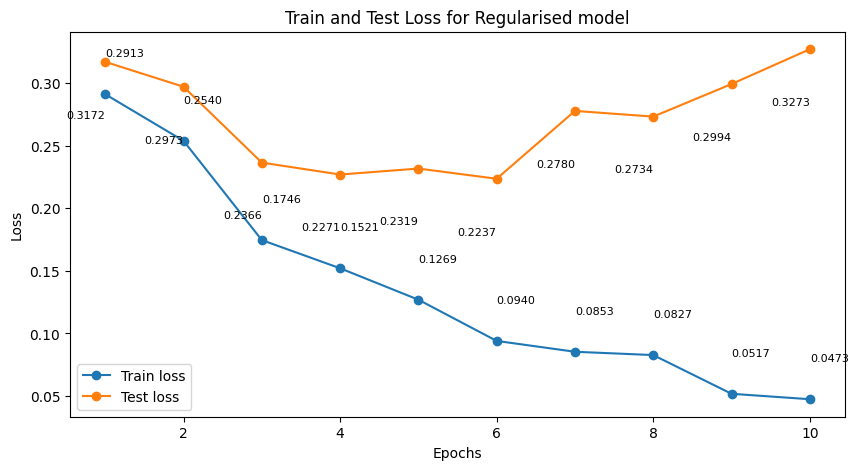

In [109]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

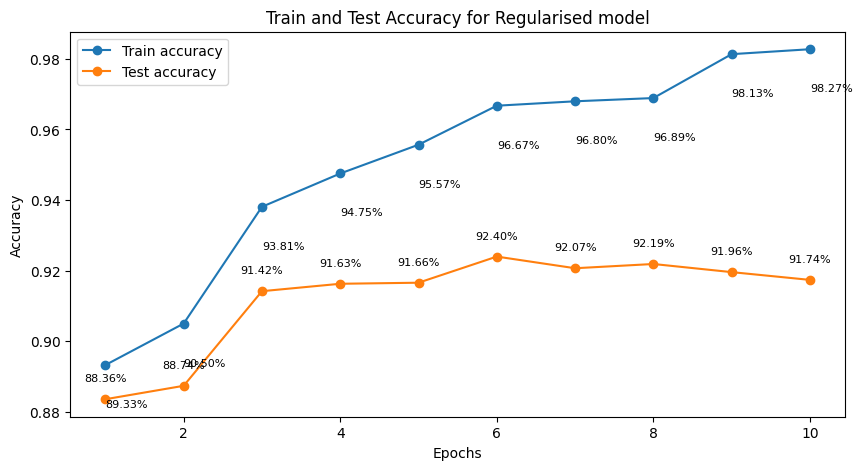

In [110]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [111]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64)

model = NetFashion(useRegularization=True).to(device) # Getting the Fashion MNIST model

epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300132  [   64/60000]
loss: 0.677288  [ 6464/60000]
loss: 0.427397  [12864/60000]
loss: 0.509596  [19264/60000]
loss: 0.323903  [25664/60000]
loss: 0.278391  [32064/60000]
loss: 0.410168  [38464/60000]
loss: 0.238174  [44864/60000]
loss: 0.246412  [51264/60000]
loss: 0.340723  [57664/60000]


Epochs:  10%|█         | 1/10 [00:28<04:19, 28.84s/it]

Train Error: 
 Accuracy: 88.1%, Avg loss: 0.321048 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.343556 

Epoch 2:

loss: 0.353734  [   64/60000]
loss: 0.335868  [ 6464/60000]
loss: 0.340808  [12864/60000]
loss: 0.259203  [19264/60000]
loss: 0.194506  [25664/60000]
loss: 0.285611  [32064/60000]
loss: 0.296854  [38464/60000]
loss: 0.180872  [44864/60000]
loss: 0.292140  [51264/60000]
loss: 0.189885  [57664/60000]


Epochs:  20%|██        | 2/10 [00:57<03:48, 28.53s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.294867 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.325553 

Epoch 3:

loss: 0.270075  [   64/60000]
loss: 0.472736  [ 6464/60000]
loss: 0.171264  [12864/60000]
loss: 0.183642  [19264/60000]
loss: 0.168273  [25664/60000]
loss: 0.167784  [32064/60000]
loss: 0.192608  [38464/60000]
loss: 0.221238  [44864/60000]
loss: 0.348385  [51264/60000]
loss: 0.245913  [57664/60000]


Epochs:  30%|███       | 3/10 [01:26<03:22, 28.92s/it]

Train Error: 
 Accuracy: 89.2%, Avg loss: 0.293121 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.331220 

Epoch 4:

loss: 0.296594  [   64/60000]
loss: 0.437543  [ 6464/60000]
loss: 0.241872  [12864/60000]
loss: 0.452230  [19264/60000]
loss: 0.378218  [25664/60000]
loss: 0.217753  [32064/60000]
loss: 0.254263  [38464/60000]
loss: 0.126993  [44864/60000]
loss: 0.283607  [51264/60000]
loss: 0.139475  [57664/60000]


Epochs:  40%|████      | 4/10 [01:55<02:52, 28.80s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.218709 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.254941 

Epoch 5:

loss: 0.280335  [   64/60000]
loss: 0.141722  [ 6464/60000]
loss: 0.509098  [12864/60000]
loss: 0.236410  [19264/60000]
loss: 0.462892  [25664/60000]
loss: 0.282941  [32064/60000]
loss: 0.178061  [38464/60000]
loss: 0.138818  [44864/60000]
loss: 0.187417  [51264/60000]
loss: 0.239004  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:24<02:24, 28.90s/it]

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.207293 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.249860 

Epoch 6:

loss: 0.163016  [   64/60000]
loss: 0.087425  [ 6464/60000]
loss: 0.306803  [12864/60000]
loss: 0.145908  [19264/60000]
loss: 0.276831  [25664/60000]
loss: 0.168265  [32064/60000]
loss: 0.189271  [38464/60000]
loss: 0.172794  [44864/60000]
loss: 0.253849  [51264/60000]
loss: 0.186826  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:52<01:54, 28.75s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.192157 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.233310 

Epoch 7:

loss: 0.142954  [   64/60000]
loss: 0.178067  [ 6464/60000]
loss: 0.155224  [12864/60000]
loss: 0.211151  [19264/60000]
loss: 0.145718  [25664/60000]
loss: 0.141332  [32064/60000]
loss: 0.235956  [38464/60000]
loss: 0.146054  [44864/60000]
loss: 0.476774  [51264/60000]
loss: 0.136289  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:21<01:26, 28.75s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.192190 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.242578 

Epoch 8:

loss: 0.101690  [   64/60000]
loss: 0.318558  [ 6464/60000]
loss: 0.096538  [12864/60000]
loss: 0.127525  [19264/60000]
loss: 0.156681  [25664/60000]
loss: 0.102450  [32064/60000]
loss: 0.249515  [38464/60000]
loss: 0.178747  [44864/60000]
loss: 0.166067  [51264/60000]
loss: 0.185481  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:50<00:57, 28.78s/it]

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.202079 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.250758 

Epoch 9:

loss: 0.132474  [   64/60000]
loss: 0.158944  [ 6464/60000]
loss: 0.177547  [12864/60000]
loss: 0.175759  [19264/60000]
loss: 0.123710  [25664/60000]
loss: 0.284545  [32064/60000]
loss: 0.084809  [38464/60000]
loss: 0.223132  [44864/60000]
loss: 0.376438  [51264/60000]
loss: 0.188003  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:18<00:28, 28.68s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.173084 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.235782 

Epoch 10:

loss: 0.058882  [   64/60000]
loss: 0.238374  [ 6464/60000]
loss: 0.155149  [12864/60000]
loss: 0.210341  [19264/60000]
loss: 0.276493  [25664/60000]
loss: 0.321413  [32064/60000]
loss: 0.136160  [38464/60000]
loss: 0.160440  [44864/60000]
loss: 0.206214  [51264/60000]
loss: 0.064034  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:47<00:00, 28.77s/it]

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.165182 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.227584 

Done training!


Plotting metrics

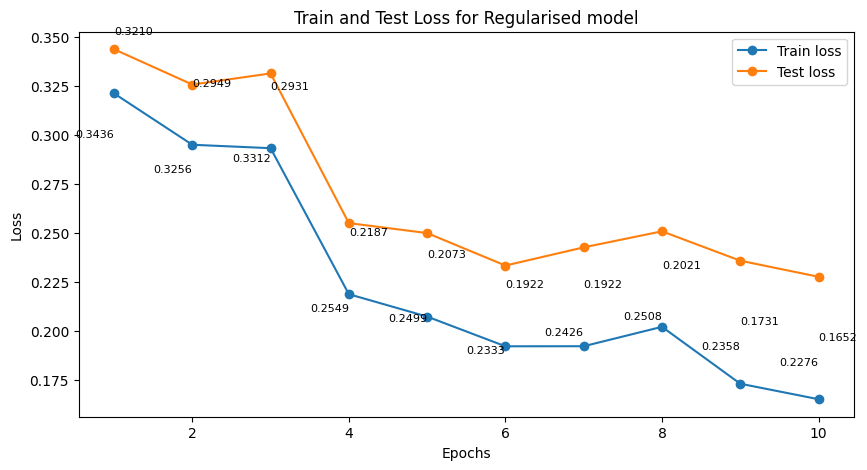

In [112]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

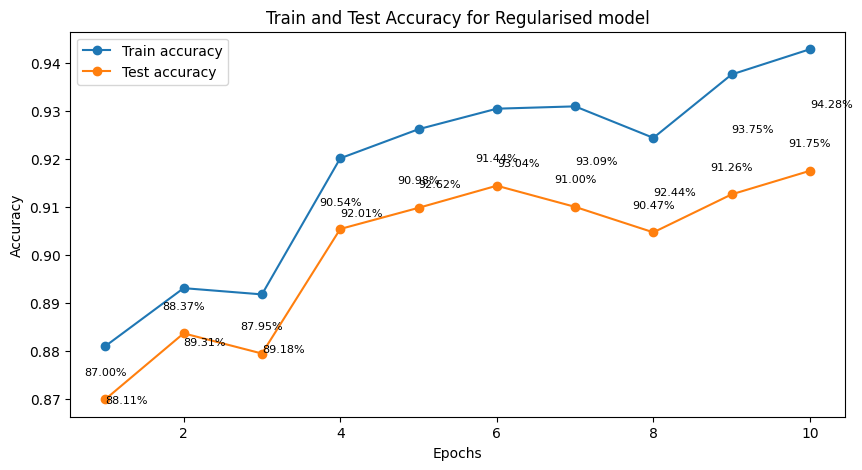

In [113]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [114]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64)

model = NetFashion(useRegularization=True, dropout_prob=0.3).to(device) # Getting the Fashion MNIST model
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.308119  [   64/60000]
loss: 0.614500  [ 6464/60000]
loss: 0.397186  [12864/60000]
loss: 0.430609  [19264/60000]
loss: 0.520584  [25664/60000]
loss: 0.285350  [32064/60000]
loss: 0.237338  [38464/60000]
loss: 0.209474  [44864/60000]
loss: 0.438670  [51264/60000]
loss: 0.195743  [57664/60000]


Epochs:  10%|█         | 1/10 [00:28<04:13, 28.17s/it]

Train Error: 
 Accuracy: 88.0%, Avg loss: 0.326121 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.351915 

Epoch 2:

loss: 0.570758  [   64/60000]
loss: 0.272157  [ 6464/60000]
loss: 0.166423  [12864/60000]
loss: 0.439721  [19264/60000]
loss: 0.349670  [25664/60000]
loss: 0.219399  [32064/60000]
loss: 0.207858  [38464/60000]
loss: 0.189261  [44864/60000]
loss: 0.380394  [51264/60000]
loss: 0.159101  [57664/60000]


Epochs:  20%|██        | 2/10 [00:56<03:47, 28.43s/it]

Train Error: 
 Accuracy: 89.8%, Avg loss: 0.279489 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.311397 

Epoch 3:

loss: 0.237783  [   64/60000]
loss: 0.280907  [ 6464/60000]
loss: 0.280049  [12864/60000]
loss: 0.247045  [19264/60000]
loss: 0.323155  [25664/60000]
loss: 0.184024  [32064/60000]
loss: 0.368254  [38464/60000]
loss: 0.452430  [44864/60000]
loss: 0.263453  [51264/60000]
loss: 0.291708  [57664/60000]


Epochs:  30%|███       | 3/10 [01:25<03:19, 28.44s/it]

Train Error: 
 Accuracy: 91.7%, Avg loss: 0.233131 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.264692 

Epoch 4:

loss: 0.317009  [   64/60000]
loss: 0.235087  [ 6464/60000]
loss: 0.178891  [12864/60000]
loss: 0.215734  [19264/60000]
loss: 0.262122  [25664/60000]
loss: 0.253384  [32064/60000]
loss: 0.208277  [38464/60000]
loss: 0.234315  [44864/60000]
loss: 0.279556  [51264/60000]
loss: 0.524161  [57664/60000]


Epochs:  40%|████      | 4/10 [01:53<02:50, 28.47s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.219626 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.258582 

Epoch 5:

loss: 0.262109  [   64/60000]
loss: 0.206093  [ 6464/60000]
loss: 0.287882  [12864/60000]
loss: 0.354615  [19264/60000]
loss: 0.373315  [25664/60000]
loss: 0.290249  [32064/60000]
loss: 0.376310  [38464/60000]
loss: 0.191317  [44864/60000]
loss: 0.182026  [51264/60000]
loss: 0.192028  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:22<02:22, 28.48s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.217094 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.258528 

Epoch 6:

loss: 0.171034  [   64/60000]
loss: 0.160721  [ 6464/60000]
loss: 0.276613  [12864/60000]
loss: 0.194928  [19264/60000]
loss: 0.223679  [25664/60000]
loss: 0.269529  [32064/60000]
loss: 0.227794  [38464/60000]
loss: 0.204391  [44864/60000]
loss: 0.181788  [51264/60000]
loss: 0.391535  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:50<01:53, 28.38s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.205902 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.250528 

Epoch 7:

loss: 0.157670  [   64/60000]
loss: 0.307006  [ 6464/60000]
loss: 0.237328  [12864/60000]
loss: 0.088293  [19264/60000]
loss: 0.186377  [25664/60000]
loss: 0.263983  [32064/60000]
loss: 0.170686  [38464/60000]
loss: 0.248225  [44864/60000]
loss: 0.218667  [51264/60000]
loss: 0.294982  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:19<01:25, 28.48s/it]

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.201313 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.250731 

Epoch 8:

loss: 0.149740  [   64/60000]
loss: 0.172709  [ 6464/60000]
loss: 0.333472  [12864/60000]
loss: 0.120259  [19264/60000]
loss: 0.248829  [25664/60000]
loss: 0.363411  [32064/60000]
loss: 0.234337  [38464/60000]
loss: 0.138964  [44864/60000]
loss: 0.268299  [51264/60000]
loss: 0.292377  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:47<00:56, 28.47s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.199574 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.254757 

Epoch 9:

loss: 0.303150  [   64/60000]
loss: 0.264803  [ 6464/60000]
loss: 0.286582  [12864/60000]
loss: 0.201592  [19264/60000]
loss: 0.150682  [25664/60000]
loss: 0.358882  [32064/60000]
loss: 0.162329  [38464/60000]
loss: 0.098251  [44864/60000]
loss: 0.259053  [51264/60000]
loss: 0.249089  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:16<00:28, 28.50s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.183212 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.239092 

Epoch 10:

loss: 0.226825  [   64/60000]
loss: 0.179277  [ 6464/60000]
loss: 0.147270  [12864/60000]
loss: 0.170817  [19264/60000]
loss: 0.141934  [25664/60000]
loss: 0.158403  [32064/60000]
loss: 0.151128  [38464/60000]
loss: 0.166124  [44864/60000]
loss: 0.107865  [51264/60000]
loss: 0.244897  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:44<00:00, 28.46s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.188626 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.249384 

Done training!


Plotting metrics

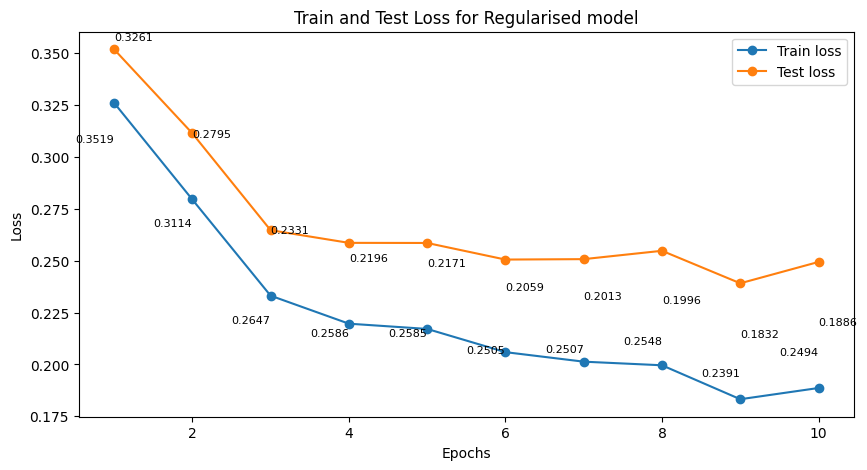

In [115]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

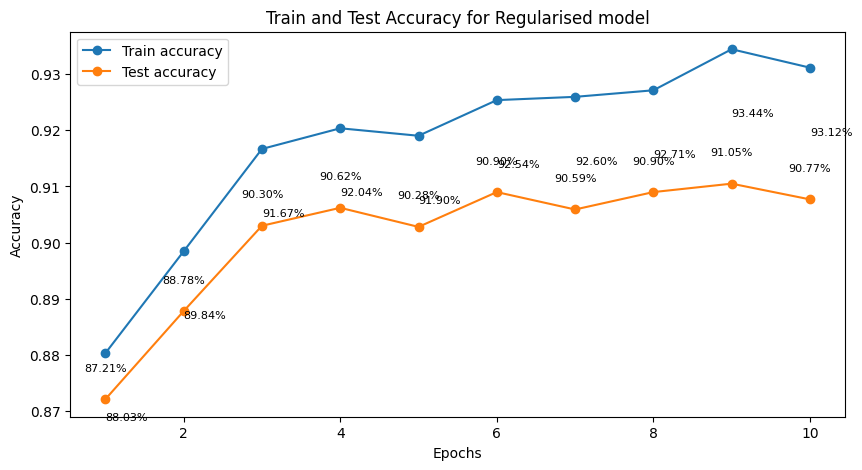

In [116]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

This excersize showed how overfitting can be spotted in the wild. In the initial example, the train and test curves are spaced apart. There is a high training accuracy (98%) but the test accuracy is less (92%). Each form of regularisation that is used decreases the train-test gap until the two lines are almost equal. (93%, 90%). Weight decay seemed particulary effective, while the CNN regularisation has less of an impact. Clearly, regularisation is something that needs to be considered when training a CNN.

